In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
class MNIST(Dataset):
    """ Kaggle's MNIST dataset. """
    def __init__(self, csv_file, transform=None):
        """
        Args: 
            csv_file (string): Path to CSV file with image pixel data
            transform (callable, optional): Optional transform applied to the sample
        """
        self.pixel_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.pixel_frame)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image = self.pixel_frame.iloc[index, 1:].to_numpy(dtype='float64').reshape(1, -1)
        label = self.pixel_frame.iloc[index, 0]
        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
tfs = transforms.Compose([
                          transforms.ToTensor(), 
                          transforms.Normalize((0.5,), (0.5,))])

data = MNIST('data/train.csv', transform=tfs)

In [13]:
lengths = (33600, 8400)
trainset, validset = torch.utils.data.random_split(data, lengths)

In [14]:
trainload = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=4, shuffle=True)
validload = torch.utils.data.DataLoader(validset, batch_size=64, num_workers=4, shuffle=True)

In [15]:
# Two hidden layers with 512 nodes each. Based of Keras docs sample. 
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.do = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.do(F.relu(self.fc1(x)))
        x = self.do(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
        

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = Network()

In [27]:
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.0001)
epochs = 35

min_valid_loss = np.Inf
valid_loss = []
train_loss = []
accuracy   = []

model.to(device)

for e in range(epochs):
    running_vl = 0
    running_tl = 0
    running_ac = 0
    nodrop_count = 0
    
    # back propogation
    for images, labels in trainload:
        images = images.view(images.shape[0], -1).float()
        images = images.to(device)
        labels = labels.to(device)
        
        opt.zero_grad()
        output = model.forward(images)
        t_loss = criterion(output, labels)
        t_loss.backward()
        opt.step()
        
        running_tl += t_loss.item()
        
    # validation pass
    model.eval()
    with torch.no_grad():
        for images, labels in validload:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.shape[0], -1).float()

            logps = model(images)
            preds = torch.argmax(logps, dim=1)
            v_loss = criterion(logps, labels)
            running_ac += (preds == labels).cpu().numpy().mean()
            running_vl += v_loss.item()
    model.train()
    
    # compute metrics for epoch
    running_tl = running_tl/len(trainload)
    running_vl = running_vl/len(trainload)
    train_loss.append(running_tl)
    valid_loss.append(running_vl)
    
    # save validation loss when minimum is broken
    if running_vl < min_valid_loss:
        print(f'---------epoch {e}---------')
        print(f'New Minimum Validation Loss: {running_vl:.6f}')
        print('Saving model...')
        torch.save(model.state_dict(), 'model2.pt')
        min_valid_loss = running_vl

---------epoch 0---------
New Minimum Validation Loss: 0.086243
Saving model...
---------epoch 1---------
New Minimum Validation Loss: 0.056415
Saving model...
---------epoch 2---------
New Minimum Validation Loss: 0.045520
Saving model...
---------epoch 3---------
New Minimum Validation Loss: 0.039294
Saving model...
---------epoch 4---------
New Minimum Validation Loss: 0.034333
Saving model...
---------epoch 5---------
New Minimum Validation Loss: 0.032740
Saving model...
---------epoch 6---------
New Minimum Validation Loss: 0.030853
Saving model...
---------epoch 7---------
New Minimum Validation Loss: 0.028058
Saving model...
---------epoch 9---------
New Minimum Validation Loss: 0.027521
Saving model...
---------epoch 12---------
New Minimum Validation Loss: 0.026312
Saving model...


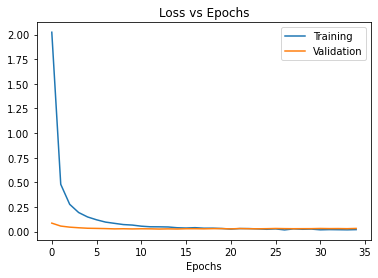

In [28]:
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.legend()
plt.show()

In [35]:
testdata = pd.read_csv('data/test.csv').to_numpy(dtype='float64')
testdata = torch.from_numpy(testdata)

In [36]:
model.load_state_dict(torch.load('model2.pt'))
out = model(testdata.float().to(device))
out = logps.to('cpu');

In [37]:
predictions = torch.argmax(out, dim=1).numpy()

In [38]:
sub_df = pd.DataFrame({
    'ImageId':range(1, len(predictions) + 1),
    'Label':predictions
})

In [39]:
sub_df.to_csv('submission.csv', index=False)